In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
import pickle

In [31]:
# open preprocessed texts
all_train = pd.read_csv("train_preprocess.csv")

# extract non-hateful comments
train = all_train.loc[all_train["hate_speech"] == 0][["preprocess"]]
train[["preprocess"]] = train[["preprocess"]].astype(str)
train = train.sample(50000)

# prepare data for modeling

max_words = 30000
max_text_length = 300 # 300 is chosen based on the distribution of texts' length

# prepare tokenizer
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(train["preprocess"])

# convert text into arrays
train1 = tokenizer.texts_to_sequences(train["preprocess"])

# pad the sentences
train_final = pad_sequences(train1, max_text_length)

In [32]:
train.size

50000

In [33]:
# define predictors and labels, we extract the last words of each comment as label
predictors, labels = train_final[:,:-1],train_final[:,-1]
# pad labels cause it's actually a classification problem
labels = ku.to_categorical(labels, num_classes = max_words)

In [34]:
# build embedding matrix
# open glove embedding
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()

# create embedding matrix
embedding_matrix = np.zeros((max_words,embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > max_words-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [35]:
# build LSTM model
model = Sequential()
model.add(Embedding(max_words,
                    embedding_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                    trainable = False
                   ))
#model.add(LSTM(units = embedding_dim, 
#               dropout = 0.2, 
#               recurrent_dropout = 0.2, 
#               return_sequences=True
#              ))
model.add(LSTM(units = embedding_dim, 
               dropout = 0.2, 
               recurrent_dropout = 0.2
              ))

model.add(Dense(max_words, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         3000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 30000)             3030000   
Total params: 6,110,400
Trainable params: 3,110,400
Non-trainable params: 3,000,000
_________________________________________________________________


In [39]:
# compile model with data
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])
result = model.fit(predictors, labels, 
                   batch_size = 128, 
                   epochs = 100, 
                  )

Epoch 1/100
391/391 [==============================] - 437s 1s/step - loss: 7.9160 - accuracy: 0.0591
Epoch 2/100
391/391 [==============================] - 419s 1s/step - loss: 7.4148 - accuracy: 0.0635
Epoch 3/100
391/391 [==============================] - 415s 1s/step - loss: 7.0801 - accuracy: 0.0772
Epoch 4/100
391/391 [==============================] - 1108s 3s/step - loss: 6.8153 - accuracy: 0.0844
Epoch 5/100
391/391 [==============================] - 411s 1s/step - loss: 6.5388 - accuracy: 0.0914
Epoch 6/100
391/391 [==============================] - 416s 1s/step - loss: 6.3141 - accuracy: 0.0972
Epoch 7/100
391/391 [==============================] - 415s 1s/step - loss: 6.1039 - accuracy: 0.1038
Epoch 8/100
391/391 [==============================] - 413s 1s/step - loss: 5.9145 - accuracy: 0.1111
Epoch 9/100
391/391 [==============================] - 412s 1s/step - loss: 5.7381 - accuracy: 0.1145
Epoch 10/100
391/391 [==============================] - 414s 1s/step - loss: 5.56

391/391 [==============================] - 423s 1s/step - loss: 2.8396 - accuracy: 0.4460
Epoch 81/100
391/391 [==============================] - 423s 1s/step - loss: 2.8306 - accuracy: 0.4491
Epoch 82/100
391/391 [==============================] - 417s 1s/step - loss: 2.8492 - accuracy: 0.4453
Epoch 83/100
391/391 [==============================] - 415s 1s/step - loss: 2.8394 - accuracy: 0.4475
Epoch 84/100
391/391 [==============================] - 413s 1s/step - loss: 2.8107 - accuracy: 0.4489
Epoch 85/100
391/391 [==============================] - 414s 1s/step - loss: 2.8120 - accuracy: 0.4497
Epoch 86/100
391/391 [==============================] - 411s 1s/step - loss: 2.8055 - accuracy: 0.4529
Epoch 87/100
391/391 [==============================] - 412s 1s/step - loss: 2.8147 - accuracy: 0.4516
Epoch 88/100
391/391 [==============================] - 411s 1s/step - loss: 2.8012 - accuracy: 0.4511
Epoch 89/100
391/391 [==============================] - 411s 1s/step - loss: 2.7908 - 

<Figure size 432x288 with 0 Axes>

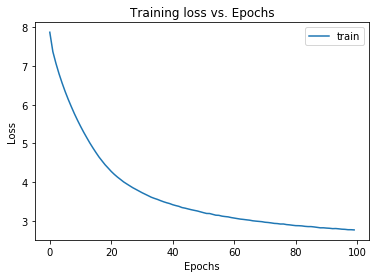

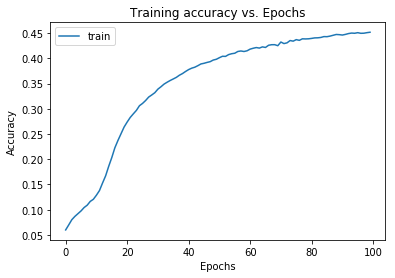

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(result.history['loss'], label = 'train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.figure()
plt.plot(result.history['accuracy'], label = 'train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.figure()

In [41]:
model.save('SpeechGenerator.h5')

In [76]:
# generating non-hate comment
seed_text = "i love you so much"
text_length = 10
  
for _ in range(text_length):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], 
                               maxlen = max_text_length - 1, 
                              )
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

i love you so much thinks world world world world world world ii ii ii


In [42]:
seed_text = "wow thanks to"
token_list = tokenizer.texts_to_sequences([seed_text])[0]

In [43]:
token_list

[1453, 20]

In [44]:
tokenizer.texts_to_sequences([seed_text])

[[1453, 20]]